In [143]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [144]:
data = pd.read_csv("Datasets\\aqi data\station_day.csv")

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB


In [146]:
data["Date"]= pd.to_datetime(data["Date"])

In [147]:
data.drop(['StationId',"Benzene",'Toluene','Xylene','NO','NOx','NH3'],axis = 1, inplace = True)

In [148]:
data.head()

,Date,PM2.5,PM10,NO2,CO,SO2,O3,AQI,AQI_Bucket
0,2017-11-24,71.36,115.75,20.65,0.10,10.76,109.26,NaN,NaN
1,2017-11-25,81.40,124.50,20.50,0.12,15.24,127.09,184.0,Moderate
2,2017-11-26,78.32,129.06,26.00,0.14,26.96,117.44,197.0,Moderate
3,2017-11-27,88.76,135.32,30.85,0.11,33.59,111.81,198.0,Moderate
4,2017-11-28,64.18,104.09,28.07,0.09,19.00,138.18,188.0,Moderate


In [149]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy = 'mean')
data['AQI'] = imp.fit_transform(data['AQI'].to_numpy().reshape(-1,1))

In [150]:
lstm_df = data

In [151]:
dates = lstm_df['Date']
lstm_df.drop('Date', axis=1,inplace=True)

In [152]:
lstm_df.drop('AQI_Bucket',axis = 1, inplace = True)

In [153]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

col_names = []
for i in lstm_df.columns:
    col_names.append(i)

lstm_df[col_names] = min_max_scaler.fit_transform(lstm_df[col_names])

In [154]:
lstm_df=lstm_df.dropna()

In [155]:
x = lstm_df.drop(columns =['AQI'])
y = lstm_df['AQI']

In [156]:
x.describe()

,PM2.5,PM10,NO2,CO,SO2,O3
count,51220.000000,51220.000000,51220.000000,51220.000000,51220.000000,51220.000000
mean,0.075794,0.157342,0.084714,0.007028,0.065065,0.042556
std,0.074626,0.125496,0.067052,0.012397,0.056486,0.048091
min,0.000130,0.000170,0.000000,0.000000,0.000000,0.000000
25%,0.029251,0.068596,0.036559,0.003185,0.030617,0.019439
50%,0.052481,0.119726,0.068521,0.005062,0.052750,0.033022
75%,0.091912,0.207055,0.114945,0.008077,0.082703,0.052545
max,0.917768,1.000000,0.887778,0.671179,0.951084,1.000000


In [157]:
dates = np.array(dates)
dates

array(['2017-11-24T00:00:00.000000000', '2017-11-25T00:00:00.000000000',
       '2017-11-26T00:00:00.000000000', ...,
       '2020-06-29T00:00:00.000000000', '2020-06-30T00:00:00.000000000',
       '2020-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [158]:
x = np.array(x)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [159]:
y = np.array(y)
y = y.reshape(-1,)

In [160]:
dates_train, x_train, y_train = dates[:1500], x[:1500], y[:1500]
dates_test, x_test, y_test = dates[1500:], x[1500:], y[1500:]

In [161]:
x_train.shape

(1500, 6, 1)

In [162]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import InputLayer

model_lstm = Sequential()

model_lstm.add(InputLayer((6,1)))

model_lstm.add(LSTM(50))

model_lstm.add(Dense(34 ,'relu'))
model_lstm.add(Dense(15 ,'relu'))

model_lstm.add(Dense(1 ,'relu' ))

In [163]:
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_18 (Dense)            (None, 34)                1734      
                                                                 
 dense_19 (Dense)            (None, 15)                525       
                                                                 
 dense_20 (Dense)            (None, 1)                 16        
                                                                 
Total params: 12,675
Trainable params: 12,675
Non-trainable params: 0
_________________________________________________________________


In [164]:
model_lstm.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['accuracy']
)

In [165]:
lstm_history = model_lstm.fit(x_train,y_train,validation_split=0.33 , epochs = 10)

Epoch 1/10
32/32 [==============================] - 4s 29ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_los

In [166]:
lstm_y_pred = model_lstm.predict(x_test)

1554/1554 [==============================] - 5s 3ms/step


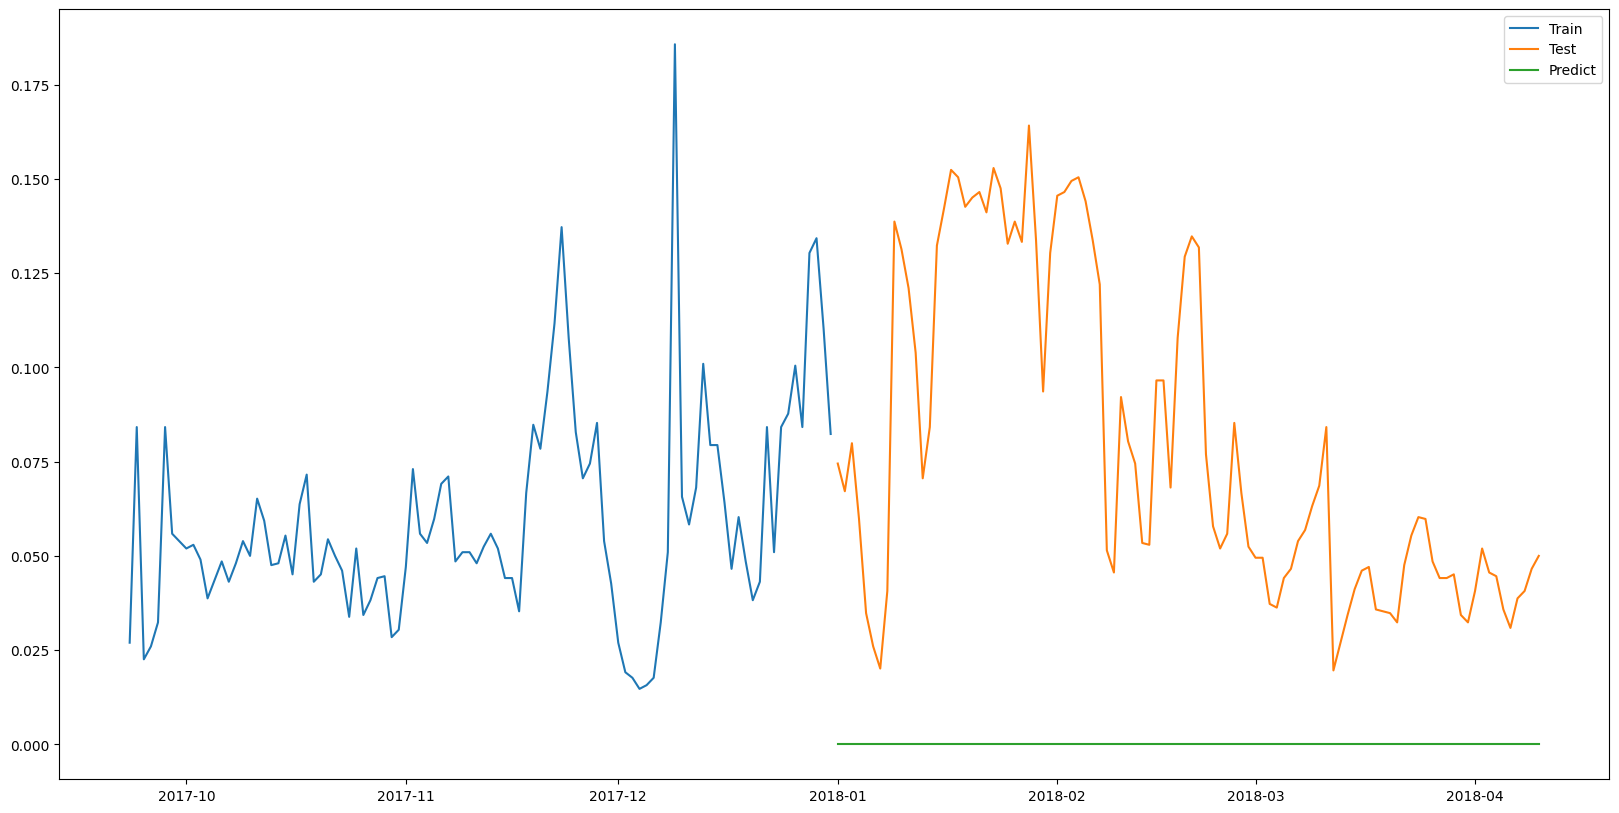

In [167]:
plt.figure(figsize = (20,10))
plt.plot(dates_train[-100:],y_train[-100:],label = "Train")
plt.plot(dates_test[:100],y_test[:100],label = "Test")
plt.plot(dates_test[:100],lstm_y_pred[:100],label = 'Predict')
plt.legend()
plt.show()

In [168]:
import pickle
file = open('api.pkl','wb')
pickle.dump(model_lstm,file)

INFO:tensorflow:Assets written to: ram://ff7025bf-98ad-4ea8-a4bf-2500a87d1b68/assets


INFO:tensorflow:Assets written to: ram://ff7025bf-98ad-4ea8-a4bf-2500a87d1b68/assets
